In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.4.1.post1
numpy version: 1.26.4
pandas version: 2.2.1
matplotlib version: 3.8.3
scanpy version: 1.9.8


# Load Data / Train-Test split
See model training notebooks for more information

In [3]:
BMMC = sp.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
data = BMMC.X

In [5]:
# USE BLOOD TYPE AS METADATA
from scipy.sparse import hstack, csc_matrix

# Rhesus factor as binary feature + -> 1, - -> 0
rh = np.array([1 if s[-1] == '+' else 0 for s in BMMC.obs['DonorBloodType']])
# Blood type as one-hot features
blood_types_ = np.array(['A', 'B', 'AB', 'O'])
blood_types = np.array([(blood_types_ == s[:-1]) *1 for s in BMMC.obs['DonorBloodType']])


#data = hstack((data,rh[:,None],blood_types))
#data = csc_matrix(data, dtype=np.float32)
data

<69249x129921 sparse matrix of type '<class 'numpy.float32'>'
	with 325339757 stored elements in Compressed Sparse Row format>

In [6]:
donors = np.unique(BMMC.obs['DonorID'])
test_donors_idx = [19593, 28045, 28483]
test_filter = np.isin(BMMC.obs['DonorID'], test_donors_idx)
train_filter = np.invert(test_filter)

n_train = np.sum(train_filter)
n_test = np.sum(test_filter)

X_test = data[test_filter]
X_train = data[train_filter]

Y_test = BMMC.obs['cell_type'][test_filter]
Y_train = BMMC.obs['cell_type'][train_filter]

train_donors = BMMC.obs[train_filter]['DonorID']

In [7]:
cell_types = np.unique(BMMC.obs['cell_type'])
main_cell_types = {
    'B Cells': ['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell'],
    'T Cells': ['CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive'],
    'Monocytes/Macrophages': ['CD14+ Mono', 'CD16+ Mono'],
    'Myeloid Progenitors': ['G/M prog' , 'ID2-hi myeloid prog'],
    'Erythroid Cells': ['Erythroblast', 'Normoblast', 'Proerythroblast'],
    'Dendritic cells': ['cDC2', 'pDC']
}
main_cell_types_sorted = sorted(list(main_cell_types.keys()))

main_cell_types_mapping = {x:k for k,v in main_cell_types.items() for x in v}
missing_cell_types = list(set(cell_types) - set(main_cell_types_mapping.keys()))
missing_cell_types.sort()
print(f"No main cell type for: {missing_cell_types}")
for missing_cell_type in missing_cell_types:
    main_cell_types_mapping[missing_cell_type] = missing_cell_type
main_cell_types_mapping

main_cell_types_sorted = sorted(list(main_cell_types.keys()) + missing_cell_types)

to_main_cell_types = lambda x: np.vectorize(main_cell_types_mapping.get)(x)

cell_types_sorted = np.concatenate((np.array([x for k,v in main_cell_types.items() for x in v]), np.array(missing_cell_types)))
cell_types_sorted

No main cell type for: ['HSC', 'ILC', 'Lymph prog', 'MK/E prog', 'NK']


array(['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell',
       'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive',
       'CD14+ Mono', 'CD16+ Mono', 'G/M prog', 'ID2-hi myeloid prog',
       'Erythroblast', 'Normoblast', 'Proerythroblast', 'cDC2', 'pDC',
       'HSC', 'ILC', 'Lymph prog', 'MK/E prog', 'NK'], dtype='<U19')

# Model Analysis

In [8]:
# load model
with open('SVM_RNAseq_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
test_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)
all_pred = best_model.predict(data)

In [10]:
test_main_pred = to_main_cell_types(test_pred)
Y_test_main = to_main_cell_types(Y_test)
train_main_pred = to_main_cell_types(train_pred)
Y_train_main = to_main_cell_types(Y_train)

## Accuracy

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

print("==== With Subtypes ====")
print(f"Train accuracy: {accuracy_score(Y_train, train_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test, test_pred):.5f}")
print("")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train, train_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test, test_pred):.5f}")
print("")
print("==== Main celltypes ====")
print(f"Train accuracy: {accuracy_score(Y_train_main, train_main_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test_main, test_main_pred):.5f}")
print("")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train_main, train_main_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test_main, test_main_pred):.5f}")

==== With Subtypes ====
Train accuracy: 0.75232
Test accuracy: 0.74269

Balanced Train Accuracy: 0.65306
Balanced Test Accuracy: 0.61352

==== Main celltypes ====
Train accuracy: 0.90859
Test accuracy: 0.89905

Balanced Train Accuracy: 0.73535
Balanced Test Accuracy: 0.70719


/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## F1 Score

In [12]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, test_pred))

/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

                     precision    recall  f1-score   support

               B1 B       1.00      0.09      0.17       508
         CD14+ Mono       0.76      0.99      0.86      2269
         CD16+ Mono       0.98      0.69      0.81       370
   CD4+ T activated       0.60      0.67      0.63      1167
       CD4+ T naive       0.37      0.92      0.52       463
             CD8+ T       0.89      0.91      0.90      5009
       CD8+ T naive       0.00      0.00      0.00       366
       Erythroblast       0.47      0.38      0.42       741
           G/M prog       0.58      0.02      0.04       617
                HSC       0.74      0.78      0.76       437
ID2-hi myeloid prog       0.00      0.00      0.00         0
                ILC       0.73      0.57      0.64       129
         Lymph prog       0.88      0.63      0.73       573
          MK/E prog       0.92      0.42      0.57       293
                 NK       0.95      0.80      0.87      1092
      Naive CD20+ B    

/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/user/gent/458/vsc45895/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
print(classification_report(Y_test_main, test_main_pred))

                       precision    recall  f1-score   support

              B Cells       0.92      0.99      0.95      2876
      Dendritic cells       1.00      0.67      0.80       759
      Erythroid Cells       0.97      0.94      0.96      1916
                  HSC       0.74      0.78      0.76       437
                  ILC       0.73      0.57      0.64       129
           Lymph prog       0.88      0.63      0.73       573
            MK/E prog       0.92      0.42      0.57       293
Monocytes/Macrophages       0.80      0.99      0.89      2639
  Myeloid Progenitors       0.33      0.02      0.04       617
                   NK       0.95      0.80      0.87      1092
              T Cells       0.92      0.99      0.95      7005

             accuracy                           0.90     18336
            macro avg       0.83      0.71      0.74     18336
         weighted avg       0.89      0.90      0.88     18336



## Confusion Matrices

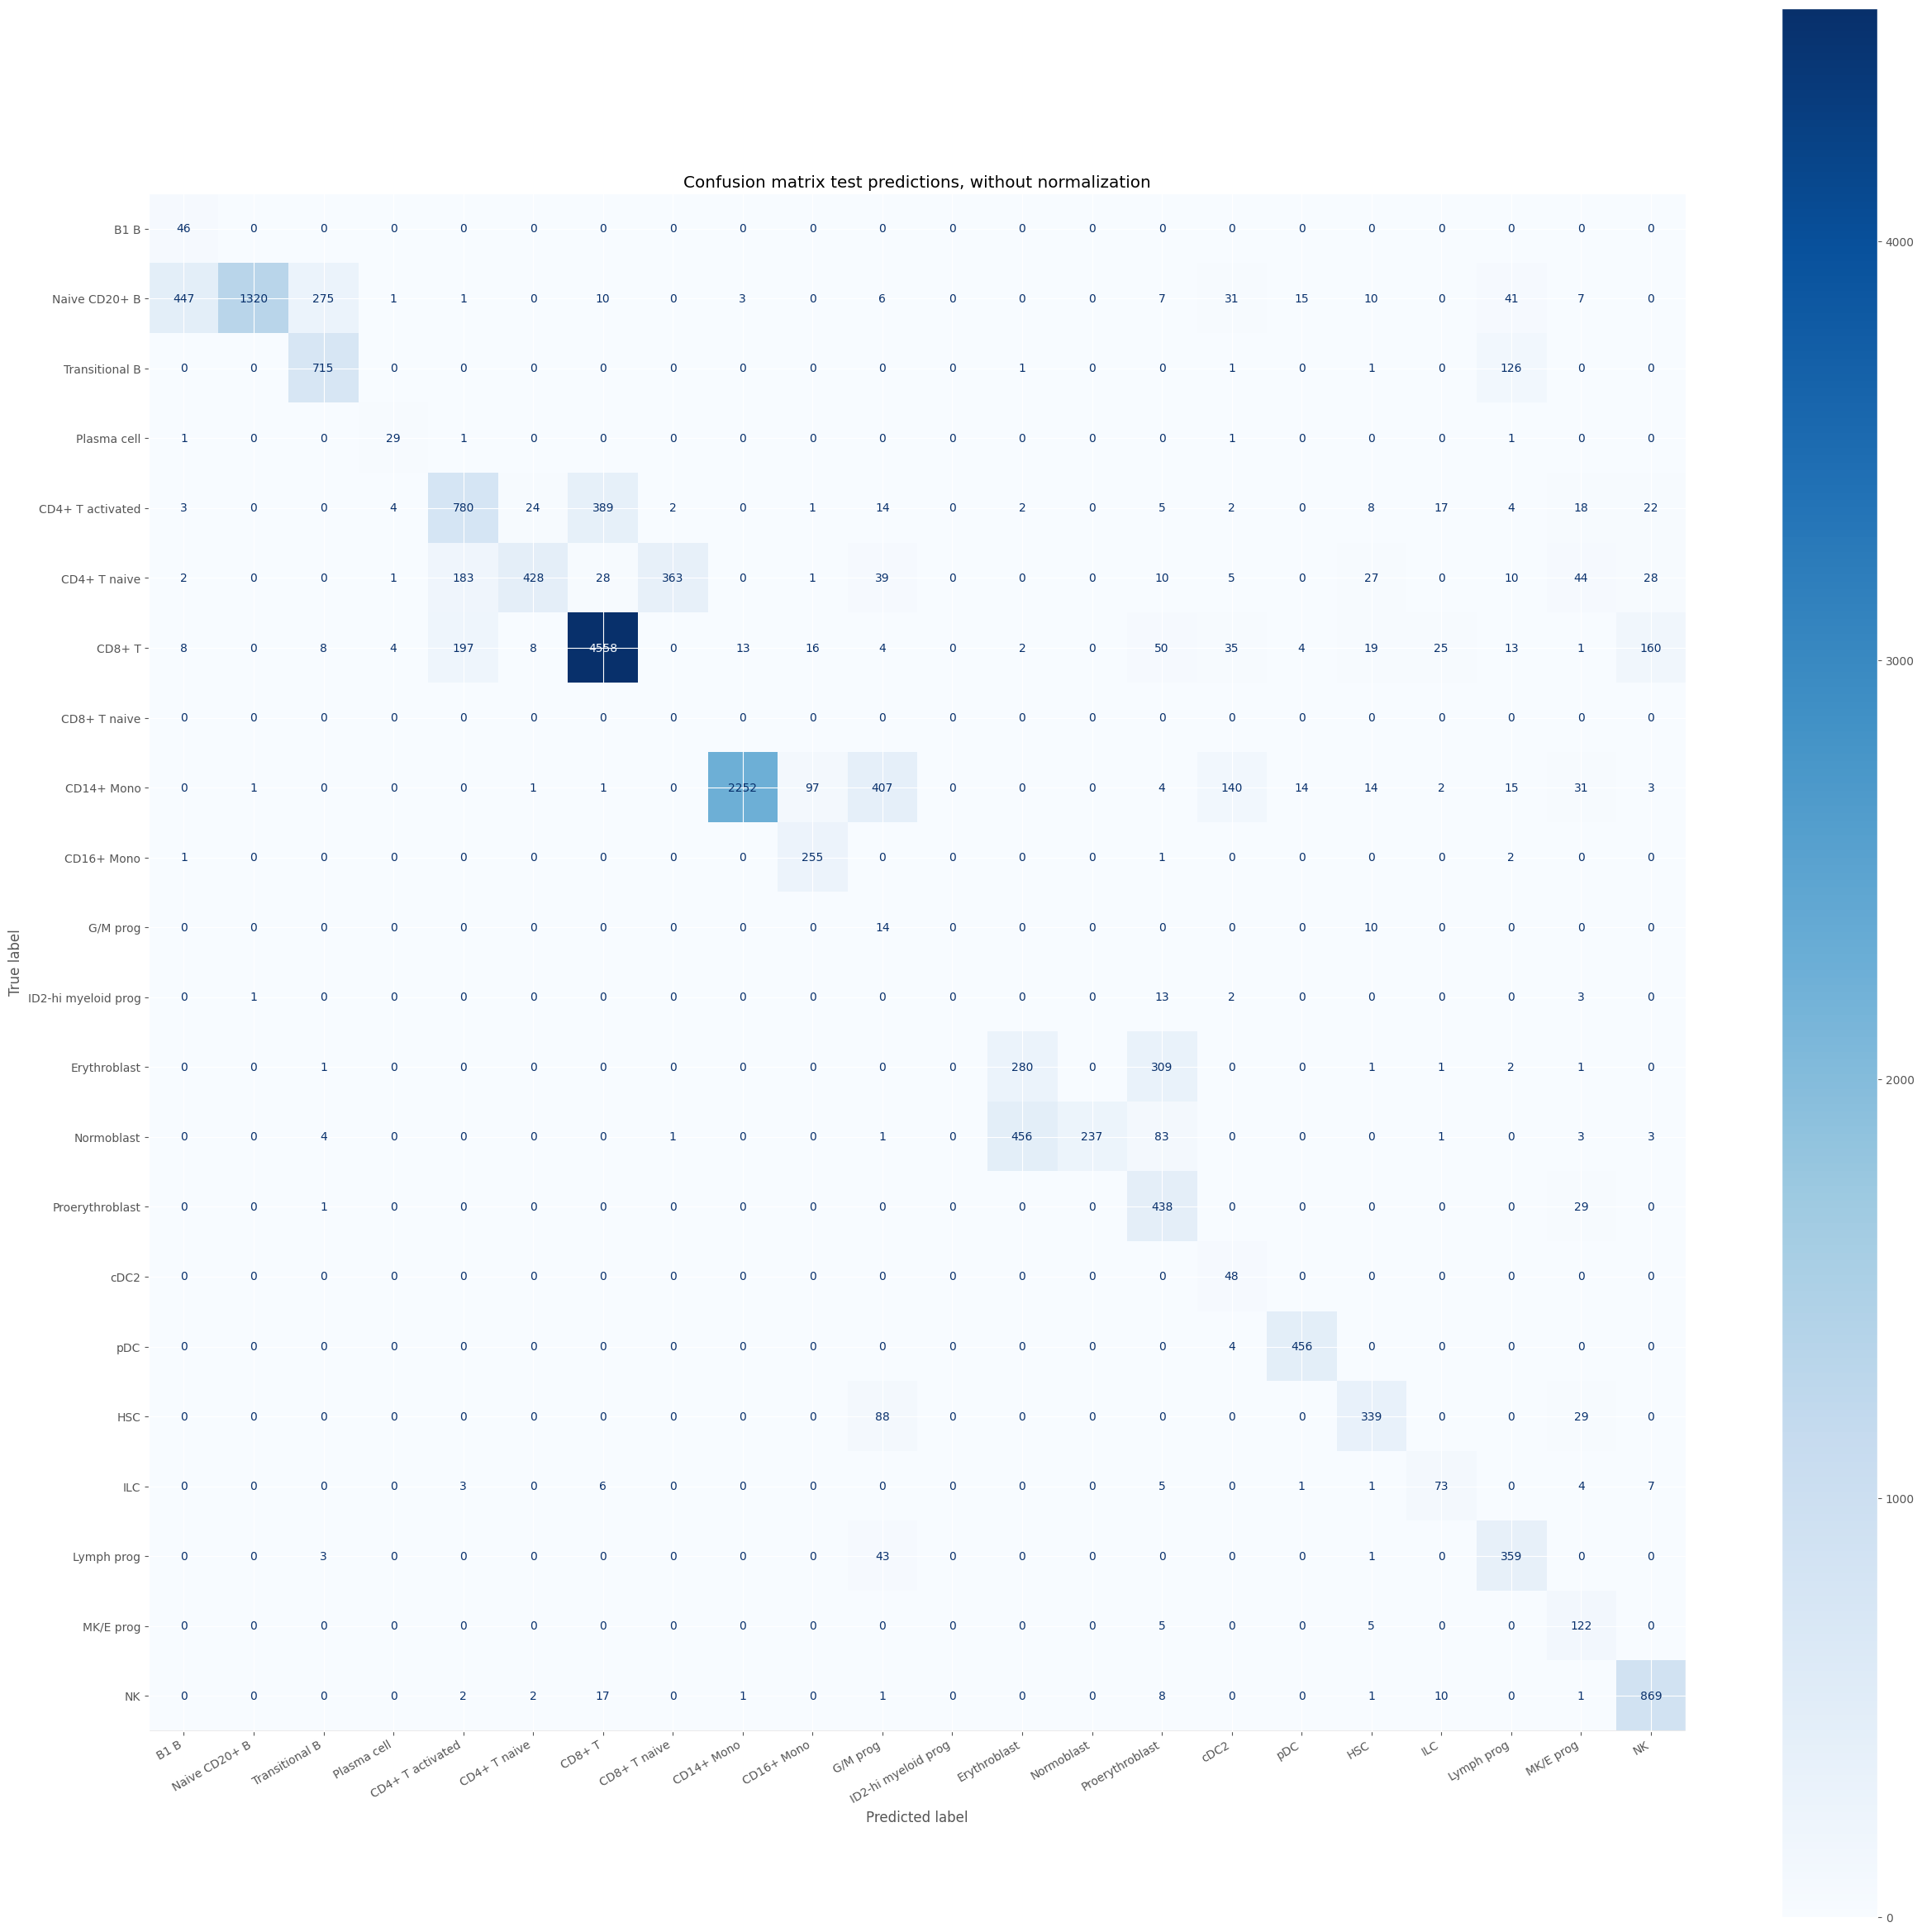

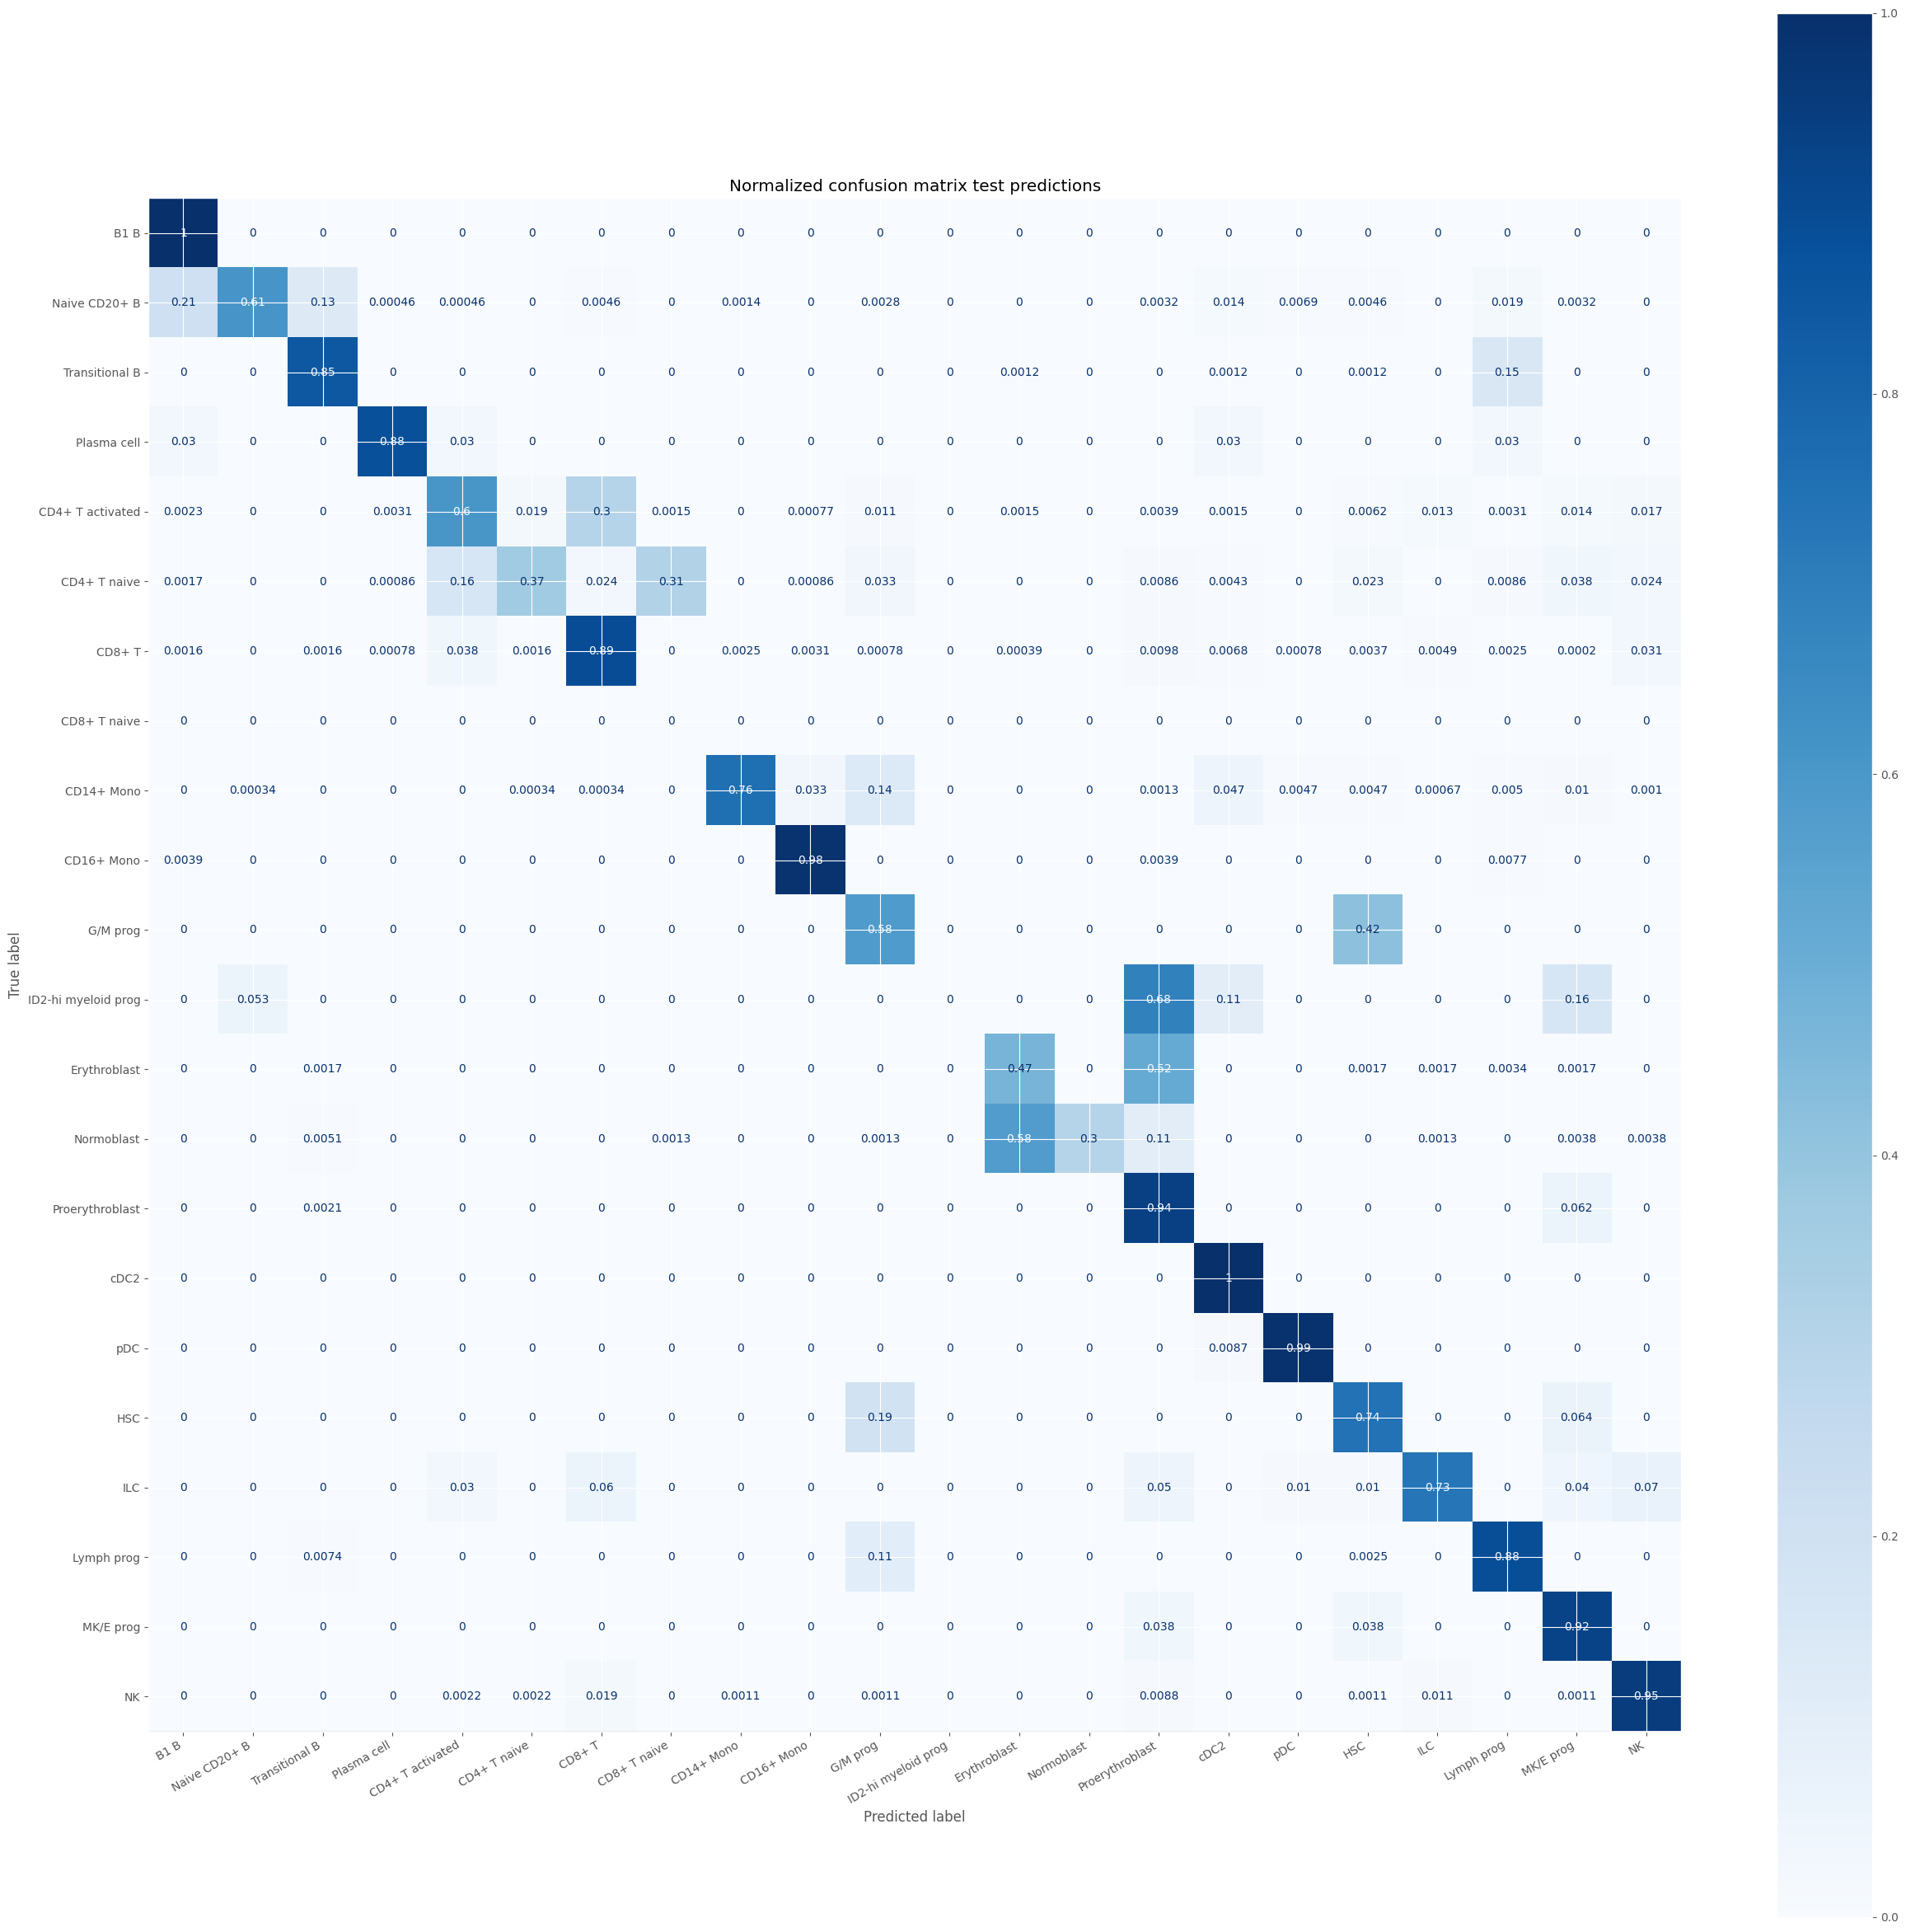

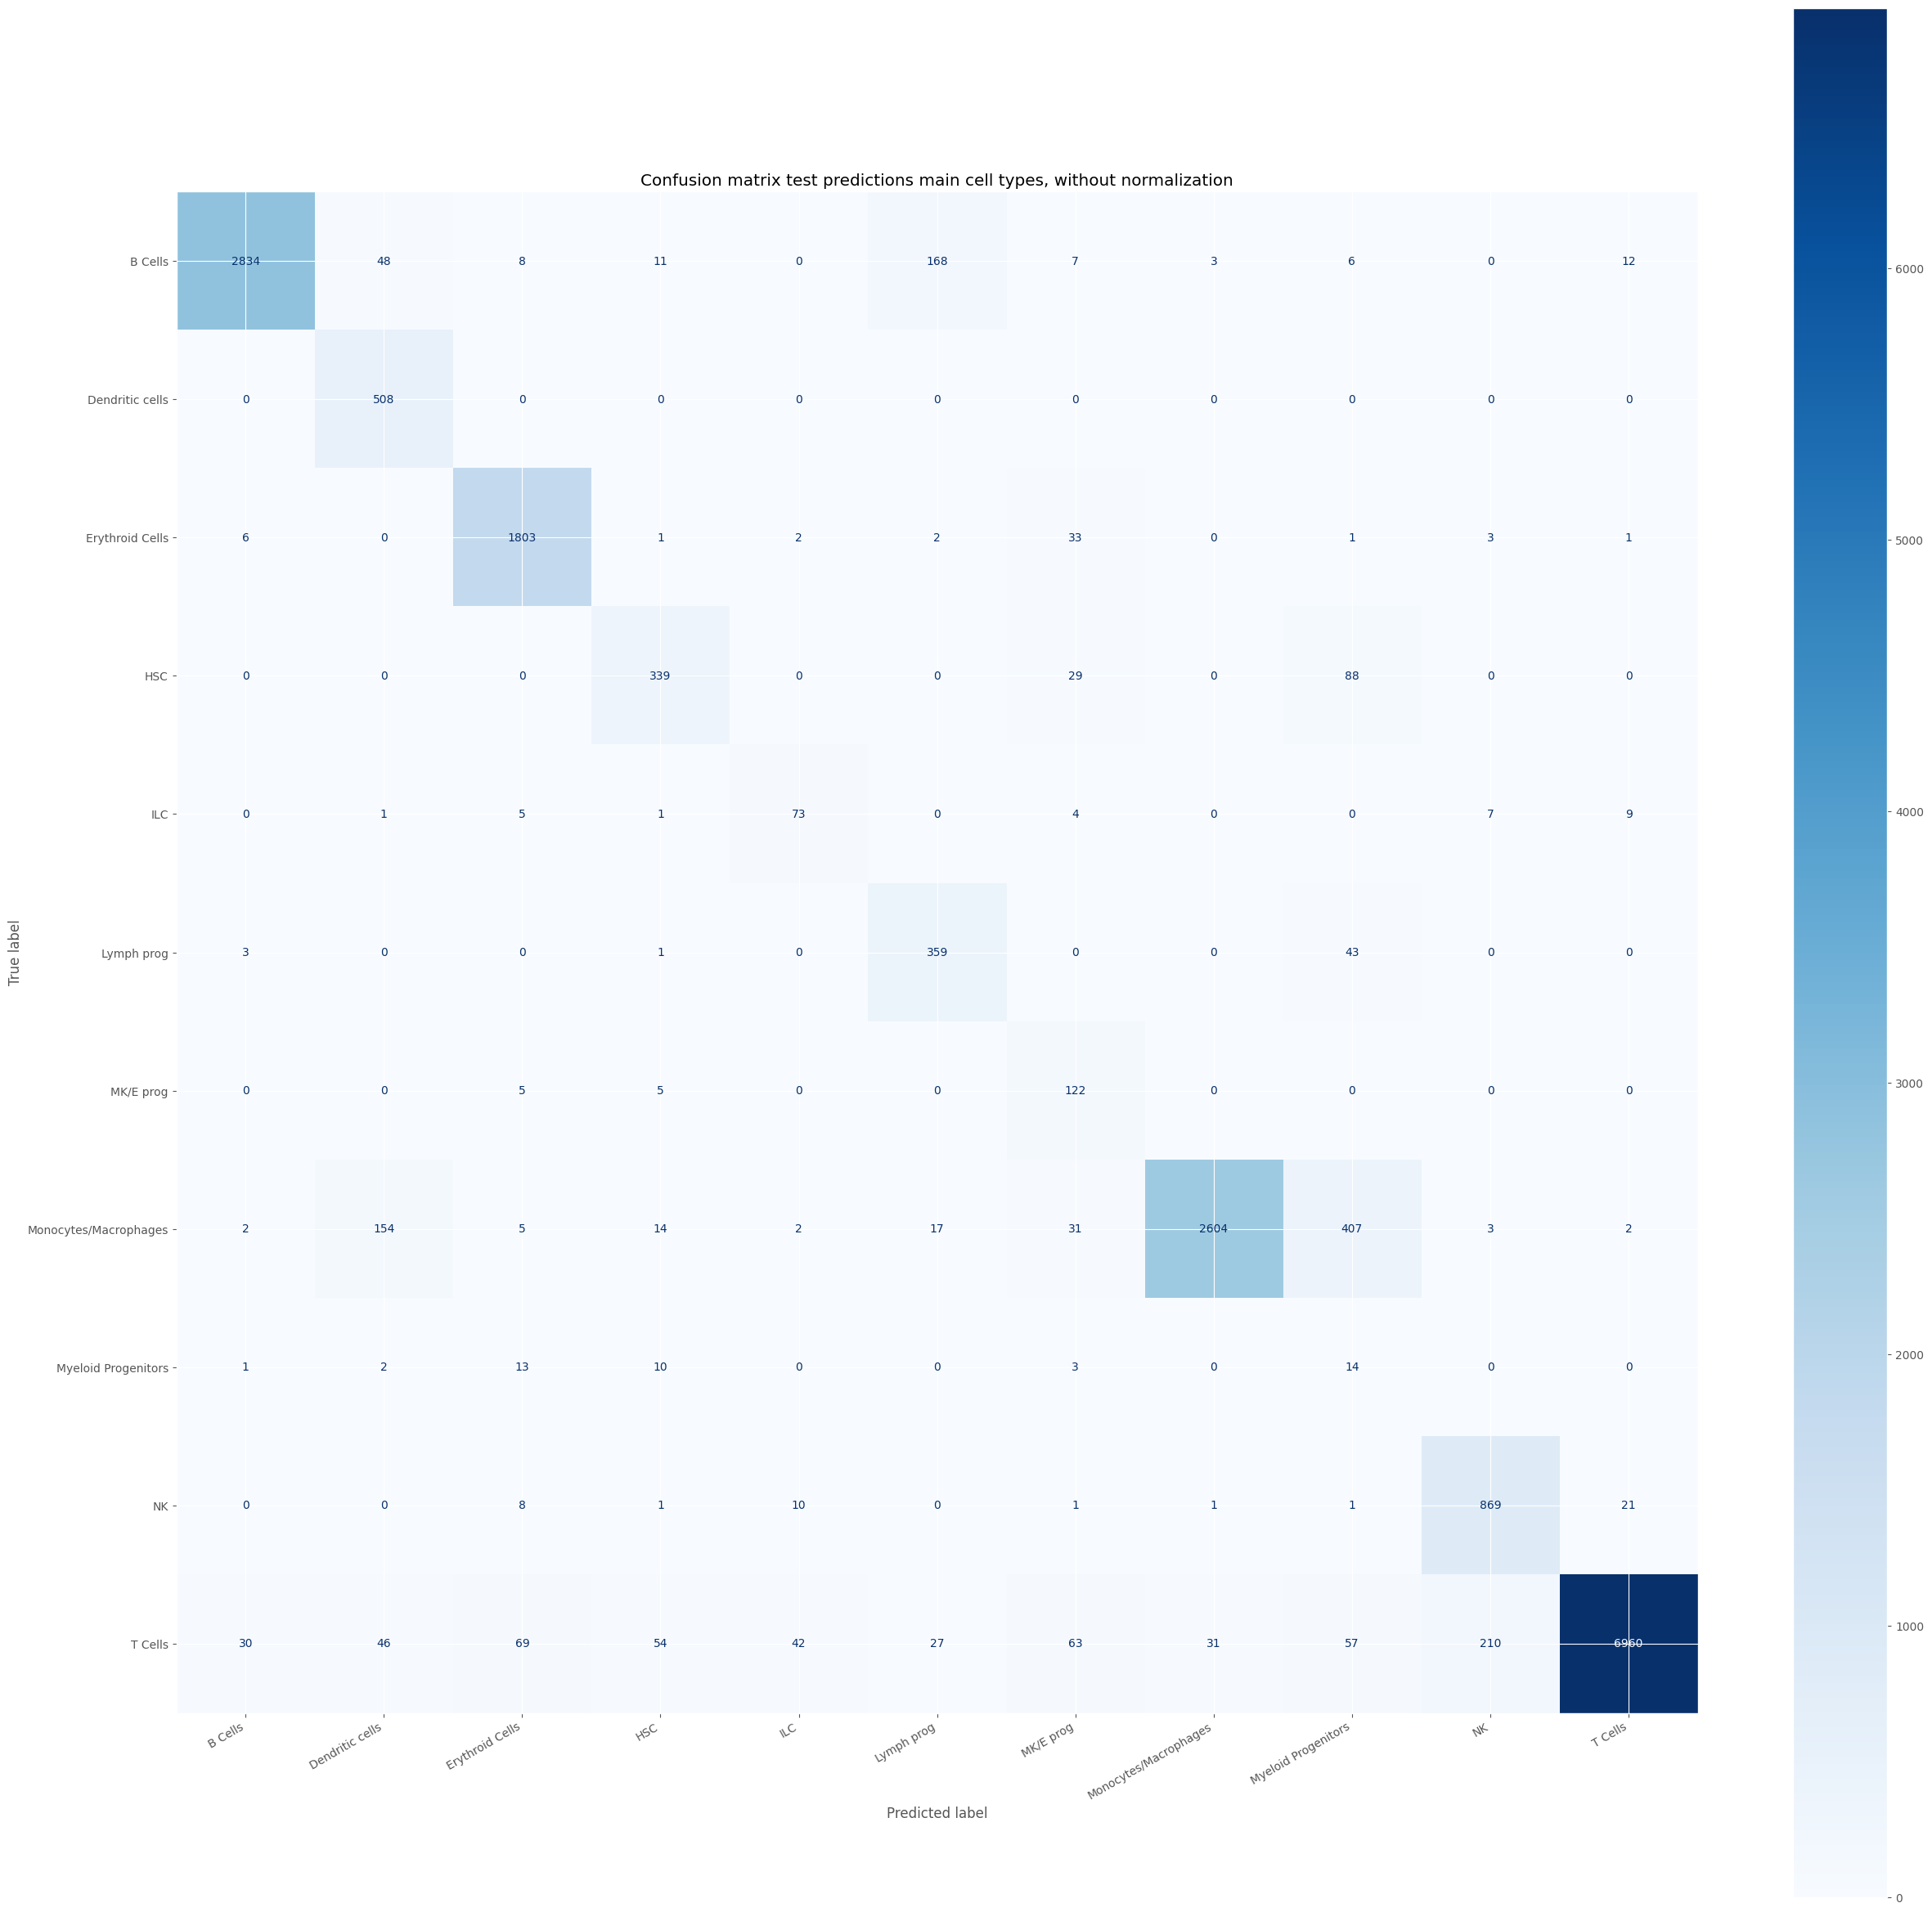

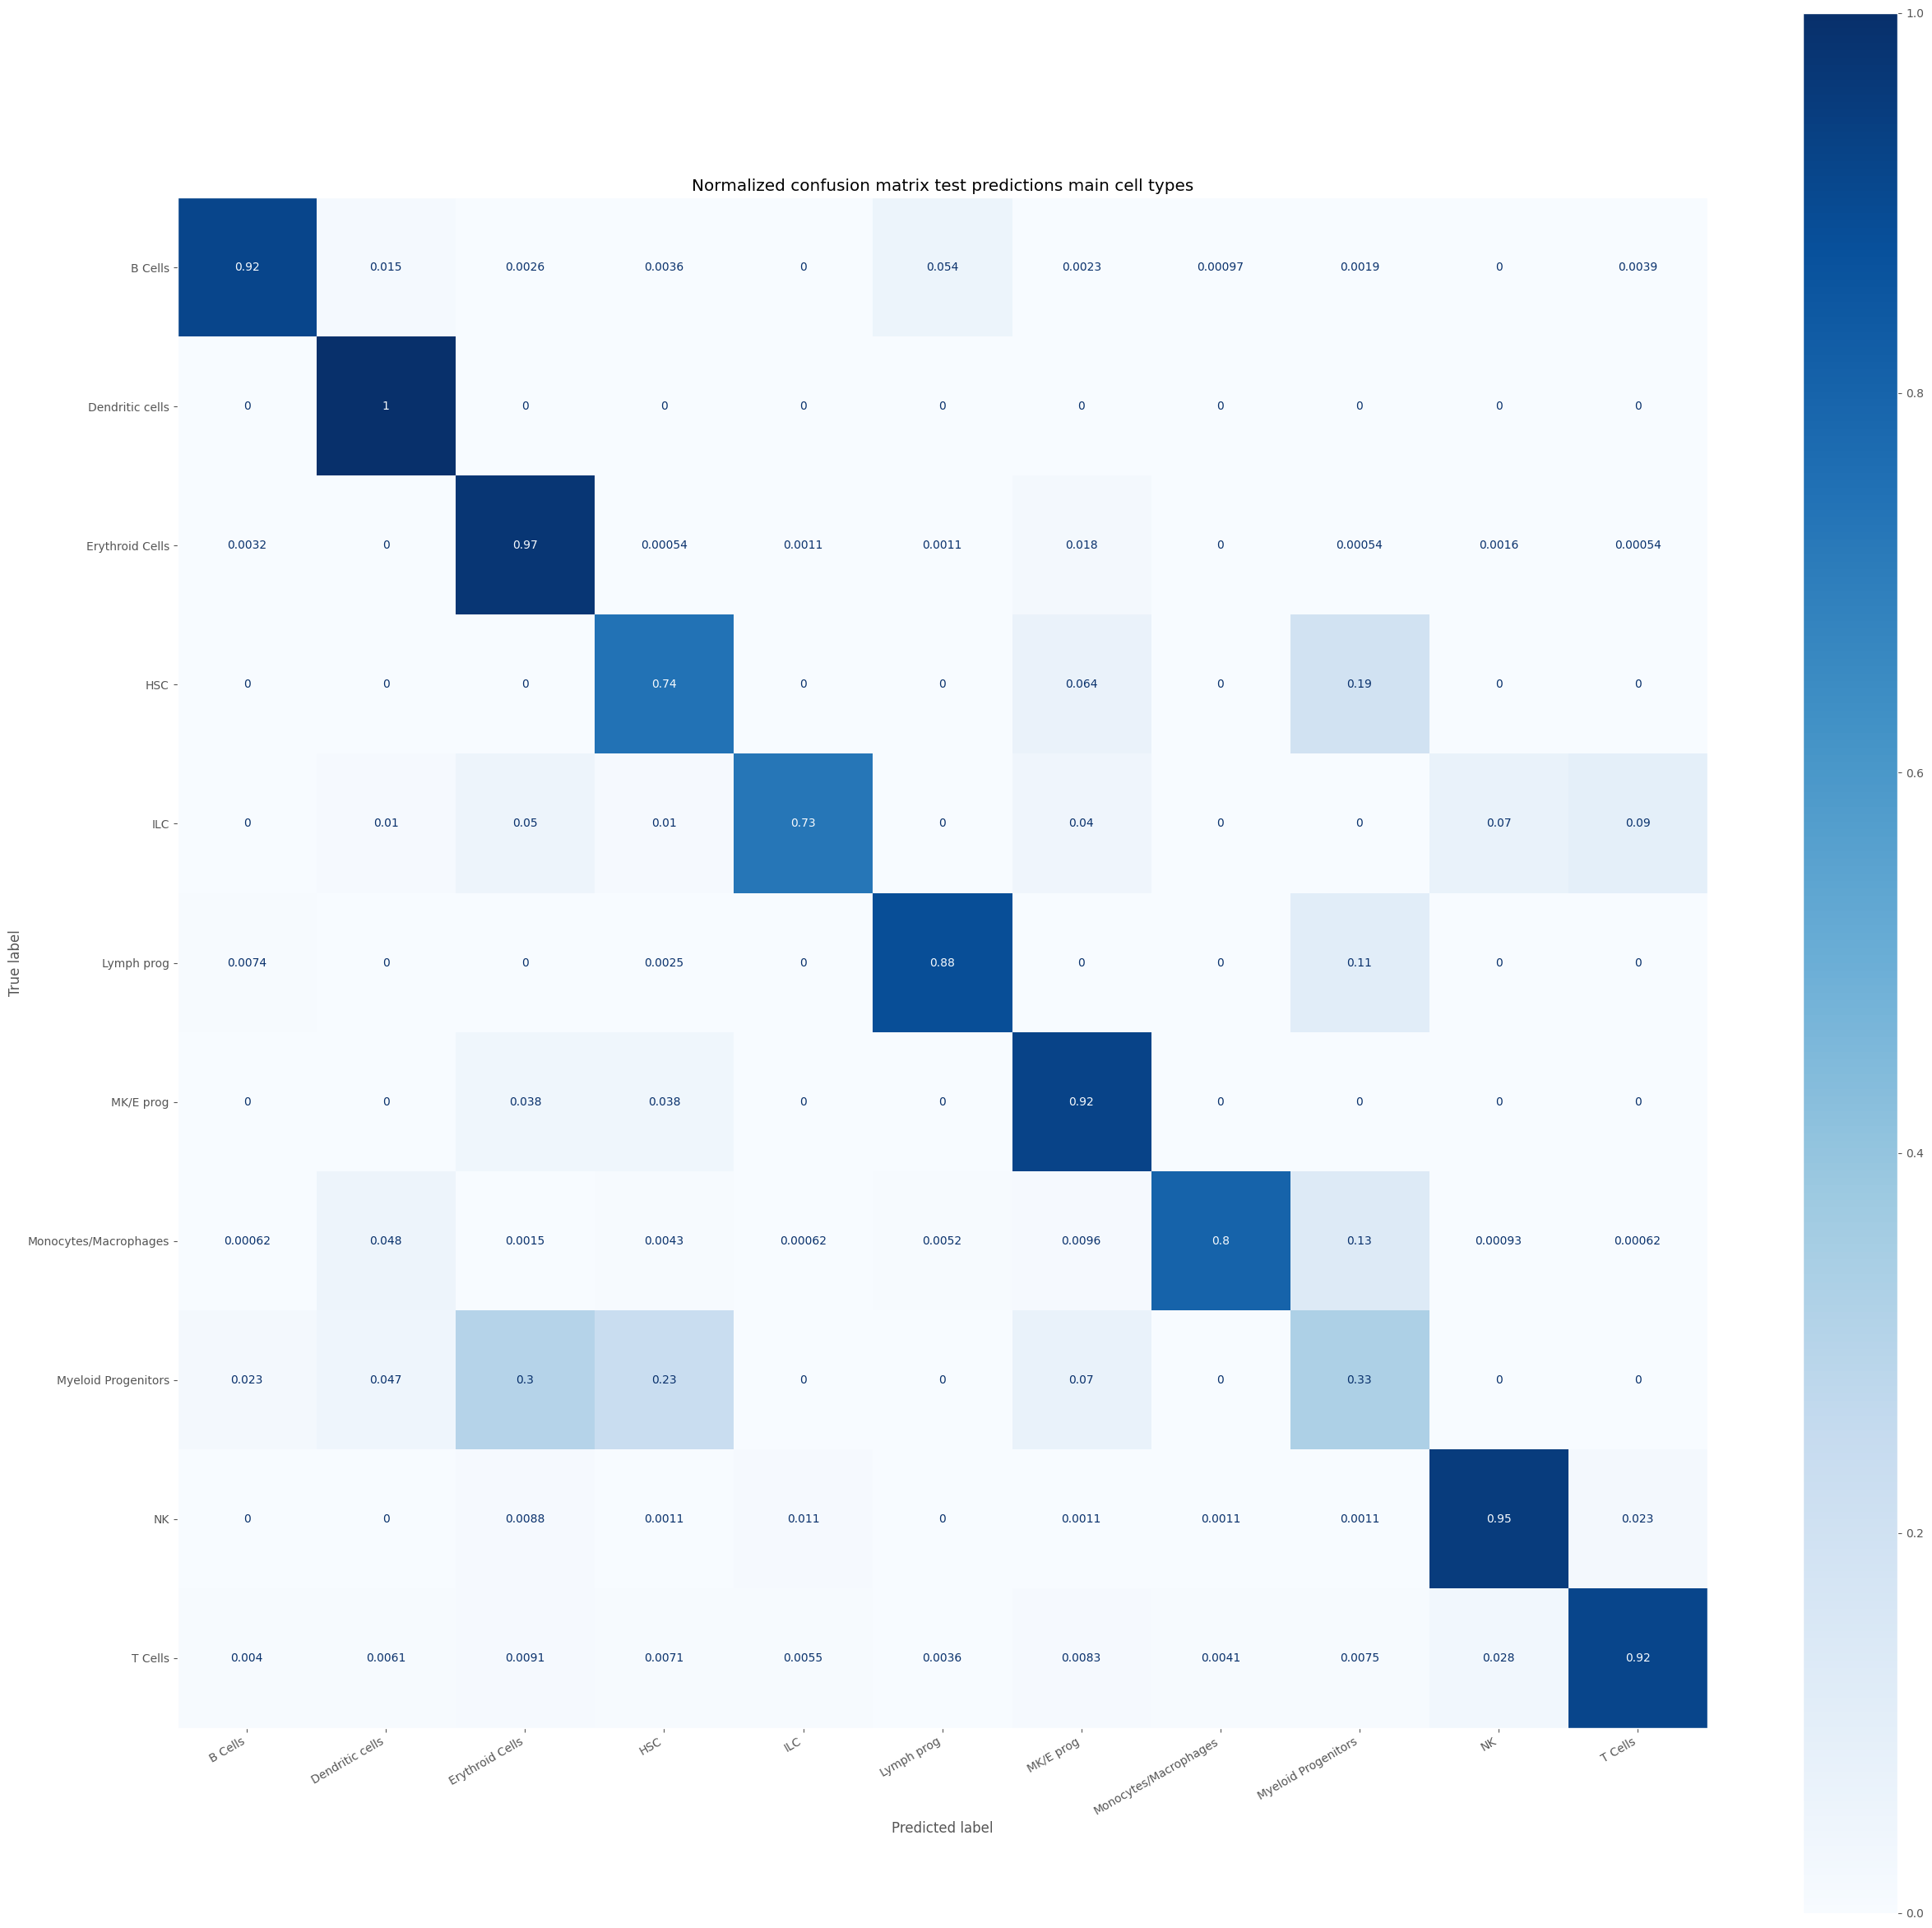

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix test predictions, without normalization", None, test_pred, Y_test, cell_types_sorted),
    ("Normalized confusion matrix test predictions", "true", test_pred, Y_test, cell_types_sorted),
    ("Confusion matrix test predictions main cell types, without normalization", None, test_main_pred, Y_test_main, main_cell_types_sorted),
    ("Normalized confusion matrix test predictions main cell types", "true", test_main_pred, Y_test_main, main_cell_types_sorted),
]
plt.rcParams['figure.figsize'] = [30, 30]
for title, normalize, pred, labels, celltypes in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        pred,
        labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
        labels=celltypes
    )
    plt.xticks(rotation=30, ha='right')
    disp.ax_.set_title(title)

plt.grid(False)
plt.show()

## Umaps

In [16]:
umap_coordinates_train = BMMC.obsm['ATAC_umap'][train_filter]
umap_coordinates_test = BMMC.obsm['ATAC_umap'][test_filter]

def show_umap(_celltypes, _umapcoords, labels, title='UMAP Plot observations', s=10):
    colors = plt.cm.get_cmap('viridis', len(_celltypes))

    for i, ct_ in enumerate(_celltypes):
        mask = (labels == ct_)
        plt.scatter(_umapcoords[mask, 0], _umapcoords[mask, 1], label=ct_, color=colors(i), s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title)
    plt.legend(title='Cell Type')
    return plt.show()

def show_predictions_umap(_umapcoords, _predictions, _labels, _celltypes, _maincelltypes=False, title='UMAP Plot prediction accuracy', s=10):
    RightPred_mask = (_predictions == _labels)
    plt.scatter(_umapcoords[RightPred_mask, 0], _umapcoords[RightPred_mask, 1], label="Right Prediction", color='green', s=s)
    
    if _maincelltypes:
        MainCellTypePred_mask = np.logical_and((to_main_cell_types(_predictions) == to_main_cell_types(_labels)), np.invert(RightPred_mask))
        plt.scatter(_umapcoords[MainCellTypePred_mask, 0], _umapcoords[MainCellTypePred_mask, 1], label="Right Main Cell Type Prediction", color='blue', s=s)
    
    WrongPred_Mask = np.invert(np.logical_or(RightPred_mask, MainCellTypePred_mask) if _maincelltypes else RightPred_mask)
    plt.scatter(_umapcoords[WrongPred_Mask, 0], _umapcoords[WrongPred_Mask, 1], label="Wrong Prediction", color='red', s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title, fontsize=30)
    l = plt.legend(title='Cell Type', fontsize=30, title_fontsize=40)
    for legendHandle in l.legendHandles:
        legendHandle._sizes = [300]
    plt.show()

In [ ]:
show_umap(cell_types_sorted, BMMC.obsm['ATAC_umap'], BMMC.obs['cell_type'], title="UMAP plot all data with cell subtypes")
show_umap(main_cell_types_sorted, BMMC.obsm['ATAC_umap'], to_main_cell_types(BMMC.obs['cell_type']), title="UMAP plot all data with main cell types")

/tmp/ipykernel_95706/4135760612.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(_celltypes))


In [ ]:
show_umap(cell_types_sorted, umap_coordinates_test, Y_test, title="UMAP plot test data with cell subtypes")
show_umap(main_cell_types_sorted, umap_coordinates_test, Y_test_main, title="UMAP plot test data with main celltypes")

In [ ]:
show_predictions_umap(umap_coordinates_test, test_pred, Y_test, cell_types_sorted, _maincelltypes=False, title='UMAP Plot prediction accuracy with subtypes', s=10)
show_predictions_umap(umap_coordinates_test, test_pred, Y_test, cell_types_sorted, _maincelltypes=True, title='UMAP Plot prediction accuracy with main celltypes', s=10)

In [ ]:
for d in donors:
    _dfilter = BMMC.obs['DonorID'] == d
    show_predictions_umap(BMMC.obsm['ATAC_umap'][_dfilter], all_pred[_dfilter], BMMC.obs['cell_type'][_dfilter], cell_types_sorted, _maincelltypes=True, title=f'UMAP Plot prediction accuracy {"test" if d in test_donors_idx else "train"} donor {d}', s=15)